# Benchmark cancer cells annotation

The objective is to compare how well three different methods recover the annotated tumor cells.
The methods are `ikarus`, `inferCNV`, `scFusion` 

## Import libraries and data

In [87]:
import os
from pathlib import Path
import gdown

import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
import pandas as pd

import anndata as ad
import scanpy as sc

from ikarus import classifier, utils, data



In [88]:
def plot_confusion_matrix(
    y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues, ax=None
):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.rcParams["figure.figsize"] = [6, 4]
    # print(classes)
    if not title:
        if normalize:
            title = "Normalized confusion matrix"
        else:
            title = "Confusion matrix, without normalization"

    # Compute confusion matrix
    cm = metrics.confusion_matrix(y_true, y_pred, labels=classes)
    # Only use the labels that appear in the data
    # classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    if ax is None:
        (fig, ax) = plt.subplots()

    im = ax.imshow(cm, interpolation="nearest", cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(
        xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        # ... and label them with the respective list entries
        xticklabels=classes,
        yticklabels=classes,
        title=title,
        ylabel="True label",
        xlabel="Predicted label",
    )
    for item in (
        [ax.title, ax.xaxis.label, ax.yaxis.label]
        + ax.get_xticklabels()
        + ax.get_yticklabels()
    ):
        item.set_fontsize(12)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(
                j,
                i,
                format(cm[i, j], fmt),
                ha="center",
                va="center",
                color="white" if cm[i, j] > thresh else "black",
            )

    return fig, ax

In [2]:
laughney_str = 'laughney_massague_2020_nsclc'
data_dir = '/root/datos/maestria/netopaas/luca/data/12_input_adatas'

This one is bigger than the ones that are already porccesed because it comes from SRA
and has been processed, by taking an elbow derivate of the cumulative sum of transcripts,
percentage of mitochondria and low complexity of transcripts.

In [3]:
adata = ad.read_h5ad(f'{data_dir}/{laughney_str}.h5ad')

# IMPORTANT we only use the tumor samples to avoid much variation
# adata = adata[(adata.obs.origin == 'tumor_primary') | (adata.obs.origin == 'normal')]
# adata = adata[(adata.obs.origin == 'tumor_primary')]
adata.obs

,sample,patient,origin,condition,tissue
120703408884123_0,GSM3516672,LX682,tumor_primary,LUAD,lung
120703409633700_0,GSM3516672,LX682,tumor_primary,LUAD,lung
120703423507166_0,GSM3516672,LX682,tumor_primary,LUAD,lung
120703423561070_0,GSM3516672,LX682,tumor_primary,LUAD,lung
120703436306869_0,GSM3516672,LX682,tumor_primary,LUAD,lung
...,...,...,...,...,...
241114576481206_16,GSM3516673,LX682,normal,LUAD,lung
241114577287974_16,GSM3516673,LX682,normal,LUAD,lung
241114589031734_16,GSM3516673,LX682,normal,LUAD,lung
241114589096668_16,GSM3516673,LX682,normal,LUAD,lung


## Intersect Ikarus vs Cell clusters

In [10]:
data_dir = '/root/datos/maestria/netopaas/luca/data/12_input_adatas'

if not Path(f"{data_dir}/laughney_ikarus.h5ad").is_file():
    gdown.download(
        "https://bimsbstatic.mdc-berlin.de/akalin/Ikarus/part_1/data/laughney20_lung/adata.h5ad",
        f"{data_dir}/laughney_ikarus.h5ad"
    )
adata_ikarus = ad.read_h5ad(f'{data_dir}/laughney_ikarus.h5ad')    

    
archive = pd.HDFStore(f'{data_dir}/PATIENT_LUNG_ADENOCARCINOMA_ANNOTATED.h5', mode='r+')
pandas_laughney = archive['NDF_ALL']
archive.close()

# laughney_counts.loc[laughney_counts.index.PHENOGRAPH_CLASS('Meta-Source').isin(['NOR', 'TUMOR'])]

We check that they correspond to each other

In [8]:
adata_ikarus[:10,:30].to_df()

,A1BG,A1CF,A2M,A2ML1,A4GALT,A4GNT,AAAS,AACS,AADAC,AADAT,...,AARSD1,AASDH,AASDHPPT,AASS,AATF,AATK,ABAT,ABC13-47488600E17.1,ABC13-47656900H15.1,ABCA1
0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,0.000000,0.0,1.943229,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.509575,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.509575
2,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,2.422809,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
5,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
6,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
7,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
8,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
9,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [11]:
pandas_laughney.iloc[:10,:].reset_index().iloc[:10,7:22]

,A1BG,A1CF,A2M,A2ML1,A4GALT,A4GNT,AAAS,AACS,AADAC,AADAT,AAED1,AAGAB,AAK1,AAMDC,AAMP
0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.771797,0.0,0.000000
1,0.000000,0.0,2.382335,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.264704,0.0,0.000000
2,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.361828,0.0,0.361828,0.0,0.000000
3,4.093525,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,2.046763,0.0,0.000000
4,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.272931,0.0,0.000000,0.0,0.000000
5,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.773375,0.0,0.000000
6,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.751539,0.0,0.000000
7,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,3.141167
8,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000
9,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000


The cell correspond to each other but they have been scaled differently. Ikarus does not consider the actual library siz per cell but only 10^4 for all cells.

We convert the `pandas` dataframe to `AnnData`

In [17]:
# The main data for the AnnData object
index_names = pandas_laughney.index.names
pandas_laughney = pandas_laughney.reset_index()
X = pandas_laughney.iloc[:, len(index_names):] # Assuming the expression data starts after the multiindex columns

# Create an AnnData object with the expression data
adata_laughney = ad.AnnData(X=X)

/usr/local/lib/python3.11/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [41]:
# Add the multiindex levels as metadata
# This assumes the first few columns are the multiindex levels
for level in index_names:
    #Strangely when using restore index, columns are not assigned well
    adata_laughney.obs[level] = pandas_laughney[level].array

In [47]:
del pandas_laughney

Get the indices of the cells that are marked as tumor in ikarus

In [43]:
ikarus_cancer = list(adata_ikarus.obs[adata_ikarus.obs.tier_0_hallmark_corrected == 'Tumor'].index)
ikarus_cancer = [int(entry) for entry in ikarus_cancer]

Check in what clusters of Laughney are the marked ikarus cells.

In [48]:
adata_laughney.obs['ascend'] = list(range(0,adata_laughney.obs.shape[0]))
adata_laughney.obs[adata_laughney.obs['ascend'].isin(ikarus_cancer)]['PHENOGRAPH_CLASS'].unique()

array(['2_MYELOID_OTHER', '1_MYELOID_OTHER', '7_MYELOID_OTHER',
       '21_MYELOID_OTHER', '28_MYELOID_OTHER', '17_MYELOID_OTHER',
       '36_MYELOID_OTHER', '25_MYELOID_OTHER', '15_MYELOID_OTHER',
       '4_MYELOID_OTHER', '3_MYELOID_OTHER', '10_MYELOID_OTHER',
       '8_MYELOID_OTHER', '35_MYELOID_OTHER', '12_MYELOID_OTHER',
       '38_MYELOID_OTHER', '0_MYELOID_OTHER', '16_MYELOID_OTHER',
       '9_MYELOID_OTHER', '24_MYELOID_OTHER', '20_MYELOID_OTHER',
       '37_MYELOID_OTHER', '6_MYELOID_OTHER', '13_MYELOID_OTHER',
       '22_MYELOID_OTHER', '26_MYELOID_OTHER', '5_LYMPHOID',
       '5_MYELOID_OTHER', '31_MYELOID_OTHER', '34_MYELOID_OTHER',
       '11_MYELOID_OTHER', '23_MYELOID_OTHER', '17_LYMPHOID',
       '29_MYELOID_OTHER'], dtype=object)

In [50]:
adata_laughney.obs['PHENOGRAPH_CLASS'].unique()

array(['0_LYMPHOID', '30_MYELOID_OTHER', '1_MYELOID_OTHER', '8_LYMPHOID',
       '9_LYMPHOID', '2_LYMPHOID', '10_MYELOID_OTHER', '17_MYELOID_OTHER',
       '10_LYMPHOID', '14_MYELOID_OTHER', '13_LYMPHOID',
       '2_MYELOID_OTHER', '25_MYELOID_OTHER', '20_MYELOID_OTHER',
       '6_LYMPHOID', '4_MYELOID_OTHER', '16_MYELOID_OTHER', '5_LYMPHOID',
       '18_MYELOID_OTHER', '3_MYELOID_OTHER', '11_LYMPHOID',
       '32_MYELOID_OTHER', '4_LYMPHOID', '15_LYMPHOID', '5_MYELOID_OTHER',
       '8_MYELOID_OTHER', '7_MYELOID_OTHER', '19_LYMPHOID',
       '13_MYELOID_OTHER', '22_MYELOID_OTHER', '21_MYELOID_OTHER',
       '0_MYELOID_OTHER', '6_MYELOID_OTHER', '3_LYMPHOID',
       '28_MYELOID_OTHER', '7_LYMPHOID', '15_MYELOID_OTHER',
       '14_LYMPHOID', '24_MYELOID_OTHER', '33_MYELOID_OTHER',
       '36_MYELOID_OTHER', '1_LYMPHOID', '35_MYELOID_OTHER',
       '38_MYELOID_OTHER', '12_LYMPHOID', '27_MYELOID_OTHER',
       '19_MYELOID_OTHER', '37_MYELOID_OTHER', '17_LYMPHOID',
       '34_MYELOID_OTHER

We can see that the cancer cells do not group in a cluster in particular, nor do they do it in the cell_types.
That is why to recover the 'expertly annotated cells' we must refer to the ikarus article, as they are not annotated in the original article.
After some search we can see that they declare how they annotated the tumor cells:

    For both input datasets, Laughney et al. lung adenocarcinoma and Lee et al. colorectal cancer, we considered a refined annotation for tumorous cells. Based on gene sets from MSigDB (v7.1) [49] hallmark collection HALLMARK_E2F_TARGETS, HALLMARK_G2M_CHECKPOINT, HALLMARK_MYC_TARGETS_V1, HALLMARK_MYC_TARGETS_V2, HALLMARK_P53_PATHWAY, HALLMARK_MITOTIC_SPINDLE, HALLMARK_HYPOXIA, HALLMARK_ANGIOGENESIS, and HALLMARK_GLYCOLYSIS, we scored each cell. If the average over all considered hallmark gene list scores (in the range 0–1) exceeds a reasonable threshold (0.45 for Laughney et al., 0.35 for Lee et al.), the cell is considered tumorous. Thresholds are chosen to minimize the amount of false positives with respect to the initial annotation of normal and tumor cell sources. The distribution of normal and tumor cell sources obtained from the initial annotation is provided in Additional File 2: Datasets.
    
**So the expert annotation is not very good because they train on a weak method to create a stronger method.**

Nevertheless we save the `ikarus` annotated tumor cells to our anndata object.

In [51]:
adata_laughney.obs['tier_0_hallmark_corrected'] = adata_ikarus.obs.tier_0_hallmark_corrected

In [52]:
del ikarus_cancer
del adata_ikarus

## **Ikarus**

### Signatures

Here we just define the path of our gene signatures of choice (find more information on how the gene lists are created [here](https://github.com/BIMSBbioinfo/ikarus/blob/master/tutorials/tutorial.ipynb).

Note: It is important that the name (see first column in the example) of the gene lists within the signatures.gmt file correspond to the cell type for which they are meaningful. signatures.gmt is tab-separated.


In [58]:
url = "https://raw.githubusercontent.com/BIMSBbioinfo/ikarus/master/tutorials/out/signatures.gmt"
os.makedirs('out', exist_ok=True)
signatures_path = "out/signatures.gmt"
gdown.download(url, signatures_path, quiet=False)
pd.read_csv(signatures_path, sep="\t", header=None)

Downloading...
From: https://raw.githubusercontent.com/BIMSBbioinfo/ikarus/master/tutorials/out/signatures.gmt
To: /root/host_home/luca/out/signatures.gmt
11.5kB [00:00, 8.90MB/s]                                                                                                                                                                                           


,0,1,2,3,4,5,6,7,8,9,...,1305,1306,1307,1308,1309,1310,1311,1312,1313,1314
0,Normal,ikarus,RP11-128M1.1,TRAV8-2,PTPRD-AS1,MEOX2,CXCL12,KLRC4-KLRK1,BCAS1,SCNN1A,...,C22ORF15,CYP4F11,AK8,LRRC18,LMO2,COL12A1,ITGA11,EGFL6,RGS11,PCDHB15
1,Tumor,ikarus,RP11-277P12.10,RP13-895J2.6,BNC1,MAGEA6,ISX,MAGEA3,RP13-614K11.2,CDH7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We also download the the pretrained model which is based on the datasets by [Laughney et. al](https://www.nature.com/articles/s41591-019-0750-6) 
and [Lee et. al.](https://pubmed.ncbi.nlm.nih.gov/32451460/).
Which is a little bit redundant.

One can train the model on the dataset of choice. To see how to do that refer to the [tutorial](https://github.com/BIMSBbioinfo/ikarus/blob/master/tutorials/tutorial.ipynb).

In [60]:
url = "https://raw.githubusercontent.com/BIMSBbioinfo/ikarus/master/tutorials/out/core_model.joblib"
os.makedirs('out', exist_ok=True)
model_path = "out/core_model.joblib"
gdown.download(url, model_path, quiet=False)

Downloading...
From: https://raw.githubusercontent.com/BIMSBbioinfo/ikarus/master/tutorials/out/core_model.joblib
To: /root/host_home/luca/out/core_model.joblib
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.00k/1.00k [00:00<00:00, 2.32MB/s]


'out/core_model.joblib'

In [61]:
model = classifier.Ikarus(signatures_gmt=signatures_path, out_dir="out",
                          # adapt_signatures=True # This is important, we are working with a reduced gen set, 
# so the model won't work if the intesrection betwen the siganture and the avialbe genes is too small..
# that is why the non-overlapping genes mus be removed from the signate. This flag does that automatically
                         ) 
model.load_core_model(model_path)

/usr/local/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 0.24.2 when using version 1.3.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


### Predict

We provide the AnnData of our data set, make predictions and save the results.
The matrix must be normalized and log1p scaled, our data has it only nomralized so 
we scale it

In [62]:
adata = adata_laughney.copy()

In [63]:
sc.pp.log1p(adata)
# adata.X = adata.layers['logcounts']
# adata = data.preprocess_adata(adata)

In [66]:
# This function works with the gene_symbol column, so we assign it
adata.var['gene_symbol'] = adata.var.index
_ = model.predict(adata, "laughney",
                  # connectivities_path='scvi_conns.npz', # If we use the connectivites from scVI the number of predicted cells changes a lot
                  save=True)

/usr/local/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:215: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']
/usr/local/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:539: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['hvg'] = {'flavor': flavor}
/usr/local/lib/python3.11/site-packages/tqdm/au

converged at iteration step: 10 with 0.0009 < 0.001


This next command computes the map but also creates the column for the colouring of the normal cells and the tumor cells

In [71]:
adata_laughney.obs["core_pred"] = model.results["core_pred"].values
adata_laughney.obs["final_pred"] = model.results["final_pred"].values

# We could use this function to calculate the umap automatically 
_ = model.get_umap(adata_laughney, "laughney", save=True)

Load prediction results and the AnnData object including the just computed UMAP coordinates.

/usr/local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/usr/local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/usr/local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


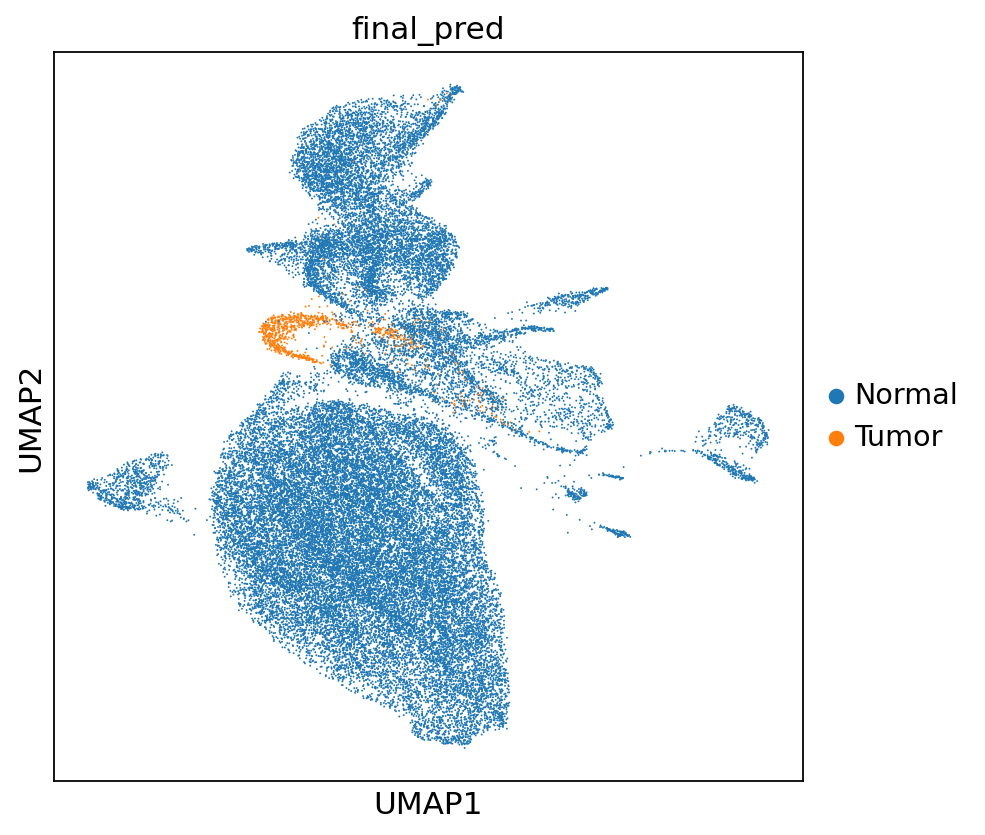

In [72]:
sc.set_figure_params(figsize=(6, 6))
sc.pl.umap(adata_laughney, color=['final_pred'])

Which leaves us with n cancer cells...

### Asses prediction

In [74]:
print(adata_laughney.obs['final_pred'] == 'Tumor').sum())
print((adata_laughney.obs['tier_0_hallmark_corrected'] == 'Tumor').sum())

962
1091


In [78]:
confusion_matrix(adata_laughney.obs['tier_0_hallmark_corrected'],
                 adata_laughney.obs['final_pred'])

array([[38835,   579],
       [  708,   383]])

              precision    recall  f1-score   support

      Normal       0.98      0.99      0.98     39414
       Tumor       0.40      0.35      0.37      1091

    accuracy                           0.97     40505
   macro avg       0.69      0.67      0.68     40505
weighted avg       0.97      0.97      0.97     40505



NameError: name 'np' is not defined

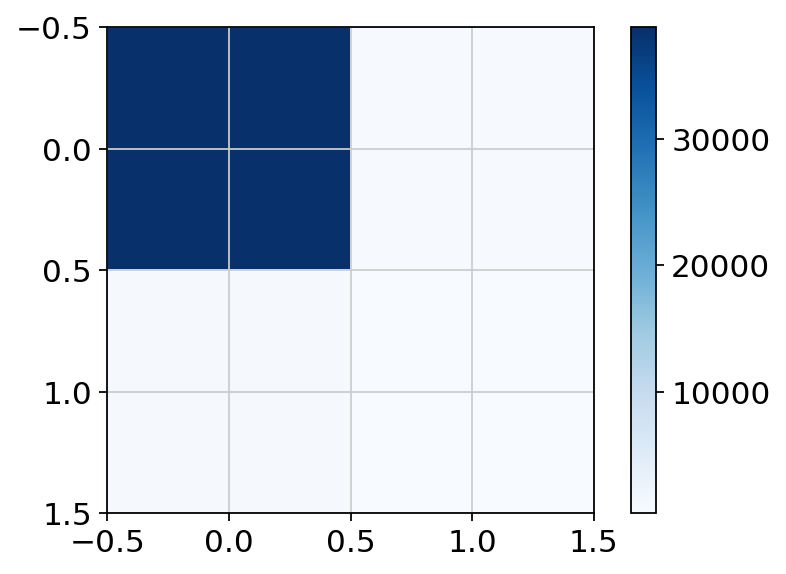

In [86]:
y = adata_laughney.obs['tier_0_hallmark_corrected']
y_pred_lr = adata_laughney.obs['final_pred']
acc = metrics.balanced_accuracy_score(y, y_pred_lr)
print(metrics.classification_report(y, y_pred_lr, labels=["Normal", "Tumor"]))
fig, ax = plot_confusion_matrix(
    y,
    y_pred_lr,
    classes=["Normal", "Tumor"],
    title=f"confusion matrix \n train on laughney+lee, test on laughney \n balanced acc: {acc:.3f}",
)
fig.tight_layout()



In [81]:
class_ikarus = classification_report(adata_laughney.obs['tier_0_hallmark_corrected'],
                 adata_laughney.obs['final_pred'], output_dict=True)

class_ikarus

{'Normal': {'precision': 0.982095440406646,
  'recall': 0.9853097884000609,
  'f1-score': 0.9836999886013906,
  'support': 39414.0},
 'Tumor': {'precision': 0.3981288981288981,
  'recall': 0.3510540788267644,
  'f1-score': 0.37311251826595226,
  'support': 1091.0},
 'accuracy': 0.9682261449203802,
 'macro avg': {'precision': 0.6901121692677721,
  'recall': 0.6681819336134127,
  'f1-score': 0.6784062534336714,
  'support': 40505.0},
 'weighted avg': {'precision': 0.9663663329476898,
  'recall': 0.9682261449203802,
  'f1-score': 0.9672538478746663,
  'support': 40505.0}}

We can see that even though the accuracy is very high, the precision for classifying tumor cells is actually very bad.
This may be due to class imbalance, but supposedly, `ikarus` considers that. 
A helpful metric for reflecting class imbalance is the $BalancedAccuracy = \frac{TPR + TNR}{2}$

In [82]:
(class_ikarus['Normal']['precision'] + class_ikarus['Tumor']['precision'])/2

0.6901121692677721

## InferCNV